# Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous part the part 1 we have learned about the feature extraction part of transfer learning now it's time to learn about new kind of transfer learning :*fine tuning*

## Creating helper functions

In previous notebooks ,we have created a bunch of helper functions,now we could rewrite them all,however this is tedious.

so,its a good idea to put functins you'll want to use use again ina script you can download and import into your notebooks(or elsewhere).

We've done this for some of the functions we've previously used here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [4]:
# Import the helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,unzip_data,walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.appliactions` and apply them to our own problem(recogizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of training data of 10 classes
unzip_data("10_food_classes_10_percent.zip")

In [6]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [7]:
# Create training and test directory patsh
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [8]:
import tensorflow as tf

In [9]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

test_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [11]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[0.00000000e+00 1.22672188e+00 2.26721972e-01]
   [5.80358505e-02 2.05803585e+00 1.05803585e+00]
   [1.00000000e+00 3.00000000e+00 2.00000000e+00]
   ...
   [5.23663330e+00 6.23663330e+00 1.02366333e+01]
   [6.94198608e+00 7.94198608e+00 1.19419861e+01]
   [8.00000000e+00 9.00000000e+00 1.30000000e+01]]

  [[3.27487379e-01 2.32748723e+00 1.32748735e+00]
   [1.05389047e+00 3.05389047e+00 2.05389047e+00]
   [1.92857170e+00 3.92857170e+00 2.92857170e+00]
   ...
   [9.09377670e+00 1.00937767e+01 1.40937767e+01]
   [9.92442799e+00 1.09244280e+01 1.49244280e+01]
   [1.08571434e+01 1.18571434e+01 1.58571434e+01]]

  [[1.49139035e+00 3.49139047e+00 2.49139047e+00]
   [2.25988555e+00 4.25988531e+00 3.25988555e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]
   ...
   [1.21859264e+01 1.11859264e+01 1.61859264e+01]
   [1.27857141e+01 1.17857141e+01 1.67857132e+01]
   [1.36469984e+01 1.26469984e+01 1.76469994e+01]]

  ...

  [[1.37867569e+02 9.32420349e+01 4.92335587e+01]
   [1

## Model 0 (Baseline Model): Building a transfer learning feature extraction model using teh Keras Functional API

The sequential API is straight forward , it runs our layers in a sequentials order.
But the functional API gives us more flexibility with our models

In [23]:
# Importing and Initializing the weights and biases callback
import wandb
wandb.login()
from wandb.integration.keras import WandbCallback

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [24]:
model_0_config={
    "architecture":"EfficientNet_B0",
    "num_classes": len(train_data_10_percent.class_names),
    "loss":"categorical_crossentropy",
    "learning_rate":0.001,
    "optimizer":"Adam",
    "batch_size":BATCH_SIZE,
    "epochs":10,
    "dataset":"ImageNet",
    "dataset_fraction":"10%"
}

In [25]:
wandb.init(project="Transfer Learning Feature Extraction",
           name="Base Model(EfficientNetB0)",
           config=model_0_config)

In [ ]:
# 1. Create a Baseline model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns arre'nt updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If you are using ResNet50v2 you will need to normalize  the inputs(you don't have to do this for EffiecientNet)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./225)(inputs)

# 5. Pass the inputs ot the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most imoprtant information,reduce the number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f"Shape after the GlobalAveragePooling2D: {x.shape}")

# 7.Create theouput activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8 . Combine the inputs with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# 10. Fit the model and saving it's history
history=model_0.fit(train_data_10_percent,
                    epochs=10,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=len(test_data_10_percent),
                    callbacks=[WandbCallback()]
                    )

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after the GlobalAveragePooling2D: (None, 1280)
Epoch 1/10
23/24 [===========================>..] - ETA: 0s - loss: 1.8757 - accuracy: 0.4389

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 51s 2s/step - loss: 1.8687 - accuracy: 0.4427 - val_loss: 1.3084 - val_accuracy: 0.7592
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1324 - accuracy: 0.7680

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 50s 2s/step - loss: 1.1324 - accuracy: 0.7680 - val_loss: 0.8926 - val_accuracy: 0.8136
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.8353 - accuracy: 0.8152

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 52s 2s/step - loss: 0.8317 - accuracy: 0.8160 - val_loss: 0.7136 - val_accuracy: 0.8404
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.8587

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 59s 3s/step - loss: 0.6861 - accuracy: 0.8587 - val_loss: 0.6201 - val_accuracy: 0.8516
Epoch 5/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5887 - accuracy: 0.8560

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 69s 3s/step - loss: 0.5898 - accuracy: 0.8547 - val_loss: 0.5636 - val_accuracy: 0.8620
Epoch 6/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5273 - accuracy: 0.8886

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 66s 3s/step - loss: 0.5257 - accuracy: 0.8880 - val_loss: 0.5248 - val_accuracy: 0.8648
Epoch 7/10
23/24 [===========================>..] - ETA: 0s - loss: 0.4722 - accuracy: 0.8967

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 62s 3s/step - loss: 0.4721 - accuracy: 0.8947 - val_loss: 0.4948 - val_accuracy: 0.8676
Epoch 8/10
23/24 [===========================>..] - ETA: 0s - loss: 0.4355 - accuracy: 0.9035

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 67s 3s/step - loss: 0.4343 - accuracy: 0.9040 - val_loss: 0.4768 - val_accuracy: 0.8688
Epoch 9/10
23/24 [===========================>..] - ETA: 0s - loss: 0.3909 - accuracy: 0.9158

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 66s 3s/step - loss: 0.3880 - accuracy: 0.9173 - val_loss: 0.4612 - val_accuracy: 0.8696
Epoch 10/10
23/24 [===========================>..] - ETA: 0s - loss: 0.3673 - accuracy: 0.9185

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250621_114806-xz3j7mw0\files\model-best)... Done. 0.1s


24/24 [==============================] - 69s 3s/step - loss: 0.3678 - accuracy: 0.9187 - val_loss: 0.4460 - val_accuracy: 0.8708


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 60ms/step - loss: 0.4460 - accuracy: 0.8708


[0.4460259675979614, 0.8707999587059021]

In [30]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_6
1 rescaling_6
2 normalization_5
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 b

In [29]:
# How about we get the summary of our base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_6 (Rescaling)        (None, None, None,   0           ['input_6[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_5 (Normalization  (None, None, None,   0          ['rescaling_6[0][0]']            
 )                              3)                                                

In [31]:
# How about a summary of our whole model??
model_0.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


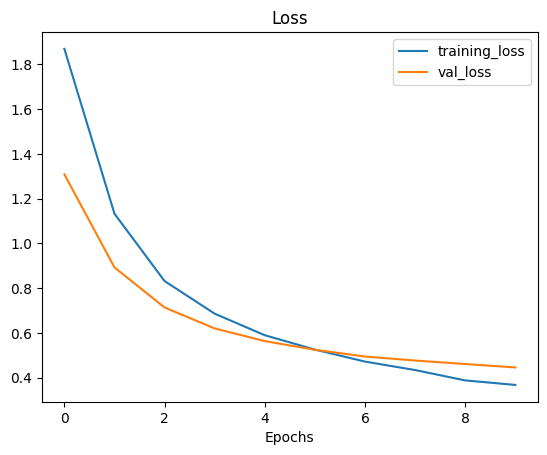

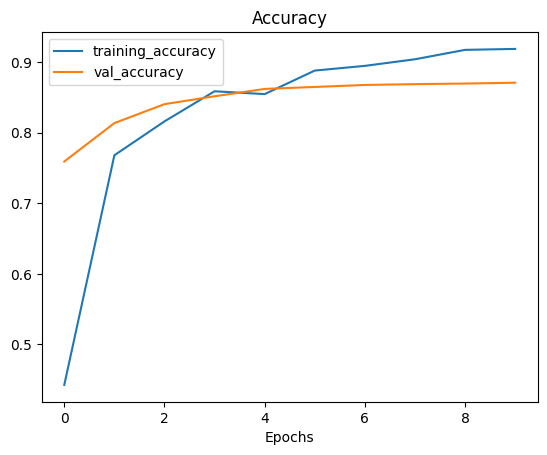

In [33]:
# Check out our model's training curves
plot_loss_curves(history)

## Getting the Feature vector from the Trained Model

Let's demonstrate the Global Avereage Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape(None,7,7,1280).

But then when it passes through GlobalAveragePooling@D,it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [50]:
# Define the input shape
input_shape=(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor{input_tensor}")
print(f"Shape of the random tensor {input_tensor.shape}")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"\n2D Global average poooled random tensor:\n{global_average_pooled_tensor}")
print(f"Shape of Global Average Pooled 2D tensor{global_average_pooled_tensor.shape}")

Random input tensor[[[[ 0.3274686  -0.84262574  0.31943363]
   [-1.4075519  -2.3880599  -1.0392478 ]
   [-0.55732334  0.5397068   1.6994323 ]
   [ 0.28893673 -1.5066115  -0.26454768]]

  [[-0.5972241  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.40604776 -3.0258412 ]
   [ 0.9058464   0.2985598  -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.4733889   0.9777269 ]
   [ 0.24694401  0.20573741 -0.52562326]
   [ 0.32410017  0.02545411 -0.1063849 ]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.40125775 -1.4145441 ]
   [-0.5931857  -1.6617213   0.33567154]
   [ 0.10815627  0.23479678 -0.5666875 ]
   [-0.35819858  0.8869861   0.52744764]]]]
Shape of the random tensor (1, 4, 4, 3)

2D Global average poooled random tensor:
[[0.9058464 1.1603122 1.6994323]]
Shape of Global Average Pooled 2D tensor(1, 3)


In [47]:
# Let's replicate the Global Average Pool 2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368648, -0.45840448, -0.28855982]], dtype=float32)>